# EVAC Examination

## Data Exploration

In [198]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
from datetime import datetime
import math


In [199]:
random.seed(datetime.now()) # Set a random seed from the clock

numInputNodes = 7
numHiddenNodes1 = 64
numOutputNodes = 1

IND_SIZE = ((numInputNodes+1) * numHiddenNodes1) +(numHiddenNodes1 * numOutputNodes)



/var/folders/01/z8y87srs6v7g5h7dy9fw6_kr0000gn/T/ipykernel_45496/3200560116.py:1: DeprecationWarning: Seeding based on hashing is deprecated
since Python 3.9 and will be removed in a subsequent version. The only 
supported seed types are: None, int, float, str, bytes, and bytearray.
  random.seed(datetime.now()) # Set a random seed from the clock


In [200]:
data = pd.read_csv('eScooterDemand.csv')
data.head()

,Date,Count,Hour,Temp,Humidity,Wind speed,Visibility,Dew point,Sunshine,Rain,Snow,Season,Public Holiday,HireAvailable
0,01/12/2017,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No,Yes
1,01/12/2017,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No,Yes
2,01/12/2017,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No,Yes
3,01/12/2017,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No,Yes
4,01/12/2017,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,No,Yes


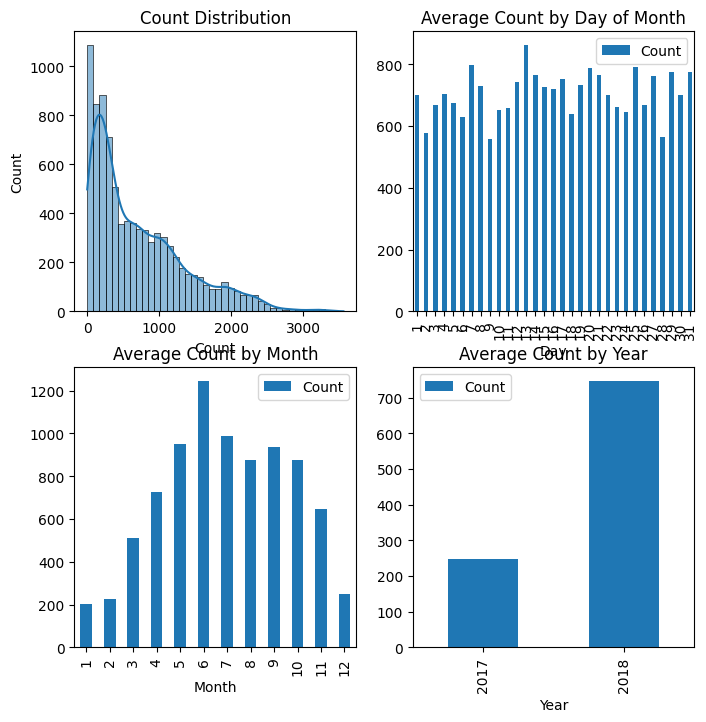

In [201]:


## plot average count over time to look for patterns that can be used to predict future demand
data['Date'] = pd.to_datetime(data['Date'], format='%d/%m/%Y')
data['Month'] = data['Date'].dt.month
data['Year'] = data['Date'].dt.year
data['Day'] = data['Date'].dt.day

## Show all plots on one figure
fig, ax = plt.subplots(2, 2, figsize=(8, 8))
sns.histplot(data['Count'], kde=True, ax=ax[0, 0]).set_title('Count Distribution')
data.groupby('Day').aggregate({'Count': 'mean'}).plot(kind='bar', ax=ax[0, 1], title='Average Count by Day of Month')
data.groupby('Month').aggregate({'Count': 'mean'}).plot(kind='bar', ax=ax[1, 0], title='Average Count by Month')
data.groupby('Year').aggregate({'Count': 'mean'}).plot(kind='bar', ax=ax[1, 1], title='Average Count by Year')
plt.show()


In [202]:
data.query("HireAvailable=='No'").head()


,Date,Count,Hour,Temp,Humidity,Wind speed,Visibility,Dew point,Sunshine,Rain,Snow,Season,Public Holiday,HireAvailable,Month,Year,Day
3144,2018-04-11,0,0,14.4,82,4.6,1041,11.3,0.0,0.0,0.0,Spring,No,No,4,2018,11
3145,2018-04-11,0,1,13.6,81,3.6,886,10.3,0.0,0.0,0.0,Spring,No,No,4,2018,11
3146,2018-04-11,0,2,12.7,80,3.9,885,9.3,0.0,0.0,0.0,Spring,No,No,4,2018,11
3147,2018-04-11,0,3,11.6,81,3.1,687,8.4,0.0,0.0,0.0,Spring,No,No,4,2018,11
3148,2018-04-11,0,4,10.2,83,3.5,554,7.4,0.0,0.0,0.0,Spring,No,No,4,2018,11


## Set up representation

In [203]:
!pip install deap

In [204]:
from deap import base, creator, tools, algorithms, gp, creator
import random
import operator


In [205]:
## Prepare data for training
data['Windspeed'] = data['Wind speed']
data['HireAvailable'] = data['HireAvailable'].map({'Yes': 1, 'No': 0})
data['PublicHoliday'] = data['Public Holiday'].map({'Yes': 1, 'No': 0})
## Create a new column for weekend and assign 1 if the day is a weekend and 0 if it is not from date
data['Weekend'] = data['Date'].dt.dayofweek.map(lambda x: 1 if x > 4 else 0)
data['Season'] = data['Season'].map({'Spring': 0, 'Summer': 1, 'Autumn': 2, 'Winter': 3})
data.head()

,Date,Count,Hour,Temp,Humidity,Wind speed,Visibility,Dew point,Sunshine,Rain,Snow,Season,Public Holiday,HireAvailable,Month,Year,Day,Windspeed,PublicHoliday,Weekend
0,2017-12-01,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,3,No,1,12,2017,1,2.2,0,0
1,2017-12-01,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,3,No,1,12,2017,1,0.8,0,0
2,2017-12-01,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,3,No,1,12,2017,1,1.0,0,0
3,2017-12-01,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,3,No,1,12,2017,1,0.9,0,0
4,2017-12-01,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,3,No,1,12,2017,1,2.3,0,0


In [206]:
data["Count"].describe()

count    8760.000000
mean      704.602055
std       644.997468
min         0.000000
25%       191.000000
50%       504.500000
75%      1065.250000
max      3556.000000
Name: Count, dtype: float64

In [207]:

class MLP(object):
    def __init__(self, numInput, numHidden, numOutput):
        self.fitness = 0
        self.numInput = numInput + 1 # Add bias node to inputs
        self.numHidden = numHidden
        self.numOutput = numOutput

        self.wh = np.random.randn(self.numHidden, self.numInput)
        self.wo = np.random.randn(self.numOutput, self.numHidden)

        self.ReLU = lambda x : max(0,x)

    def sigmoid(self,x):
        try:
            ans = (1 / (1 + math.exp(-x)))
        except OverflowError:
            ans = float('inf')
        return ans
    
    def feedForward(self, inputs):
      inputsBias = inputs[:]
      inputsBias.insert(len(inputs),1)                 # Add bias input
      h1 = np.dot(self.wh, inputsBias)                 # feed to hidden layer
      h1 = [self.ReLU(x) for x in h1]              # Activate hidden layer
      output = np.dot(self.wo, h1)                 # feed to output layer
      # output = [self.sigmoid(x) for x in output]   # Activate output layer
      return output
    
    def getWeightsLinear(self):
        flat_wh = list(self.wh.flatten())
        flat_wo = list(self.wo.flatten())
        return( flat_wh + flat_wo )

    def setWeightsLinear(self, Wgenome):
        numWeights_IH = self.numHidden * (self.numInput)
        self.wh = np.array(Wgenome[:numWeights_IH])
        self.wh = self.wh.reshape((self.numHidden, self.numInput))
        self.wo = np.array(Wgenome[numWeights_IH:])
        self.wo = self.wo.reshape((self.numOutput, self.numHidden))

myNet = MLP(numInputNodes, numHiddenNodes1, numOutputNodes)



In [208]:
creator.create("FitnessMax", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register("attr_float", random.uniform, 0, 1.0)
toolbox.register("individual", tools.initRepeat, creator.Individual,
                 toolbox.attr_float, n=IND_SIZE)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


In [209]:
import numpy
# randomise data
data = data.sample(frac=1).reset_index(drop=True)
data = data[:500]
stats_fit = tools.Statistics(lambda ind: ind.fitness.values)
stats_size = tools.Statistics(len)
mstats = tools.MultiStatistics(fitness=stats_fit, size=stats_size)
mstats.register("avg", numpy.mean)
mstats.register("std", numpy.std)
mstats.register("min", numpy.min)
mstats.register("max", numpy.max)


In [210]:
def eval(individual, myNet):
  myNet.setWeightsLinear(individual)
  fitness = 0
  for i in range(len(data)):
    input = [data['Temp'][i], data['Windspeed'][i], data['Visibility'][i], data['PublicHoliday'][i], data['Weekend'][i], data['Month'][i], data['Hour'][i]]
    output = myNet.feedForward(input)
    if output[0] < 0:
      return 1000000000,
    if output[0] > 100000:
      return 1000000000,
    fitness += abs(output[0] - data['Count'][i])
  return fitness,


In [211]:
toolbox.register("evaluate", eval)

toolbox.register("select", tools.selTournament, tournsize=3)

toolbox.register("mutate", tools.mutGaussian, mu=0.0, sigma=0.5, indpb=0.2)

toolbox.register("population", tools.initRepeat, list, toolbox.individual)

baseline = toolbox.evaluate(myNet.getWeightsLinear(), myNet)
print(baseline)

(1546448.0963782722,)


In [212]:
stats = tools.Statistics(key=lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)

In [213]:
## SANITYY CHECK
ind = toolbox.individual()
print(ind)
ind.fitness.values = toolbox.evaluate(ind, myNet)
print(ind.fitness.valid)
print(myNet.setWeightsLinear(ind))
print(myNet.feedForward([-10, 4, 3, 2, 1, 5, 5]))
print(toolbox.evaluate(ind, myNet))

[0.33978342957781704, 0.09589915298753482, 0.8598137903824495, 0.7398275554802041, 0.2412024074704382, 0.18490370462397054, 0.40139477705416227, 0.3524985268416424, 0.31676185451937455, 0.15852700910323148, 0.8085064804439629, 0.03065651398372604, 0.32264469116243477, 0.046587096483938106, 0.19165570639405982, 0.3787478695633505, 0.09812953225773424, 0.086326249924639, 0.6023302515835044, 0.5678853099482504, 0.38027771146712985, 0.30614960160956806, 0.6171480058403216, 0.9984964796625904, 0.02270542843468515, 0.14080509903004423, 0.6752775069796044, 0.09471121574075148, 0.09073463142750993, 0.8216851529586002, 0.5303386040737614, 0.3639718184739946, 0.9995845622259766, 0.5686150647949566, 0.25013552847127185, 0.8481012810156008, 0.9907224443557716, 0.4144836153164376, 0.24541386419142552, 0.22228128676561754, 0.7115067619762501, 0.40644128456276674, 0.1372528950601518, 0.6562062286432842, 0.9091798308770732, 0.9813213481296191, 0.2501477283824004, 0.05051319639113194, 0.290313615168022

In [214]:
logbook = tools.Logbook()

pop = toolbox.population(n=100)

In [215]:
fitnesses = [toolbox.evaluate(indiv, myNet) for indiv in pop]
for ind, fit in zip(pop, fitnesses):
    ind.fitness.values = fit

In [216]:
NGEN = 200

for g in range(NGEN):
    print("-- Generation %i --" % g)
      
    offspring = toolbox.select(pop, len(pop))
    offspring = list(map(toolbox.clone, offspring))

    for mutant in offspring:
        toolbox.mutate(mutant)
        del mutant.fitness.values
                         
    invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
    fitnesses = [toolbox.evaluate(indiv, myNet) for indiv in invalid_ind]
    for ind, fit in zip(invalid_ind, fitnesses):
         ind.fitness.values = fit
    
    pop[:] = offspring
    record = stats.compile(pop)
    logbook.record(gen=g, **record)


-- Generation 0 --
-- Generation 1 --
-- Generation 2 --
-- Generation 3 --
-- Generation 4 --
-- Generation 5 --
-- Generation 6 --
-- Generation 7 --
-- Generation 8 --
-- Generation 9 --
-- Generation 10 --
-- Generation 11 --
-- Generation 12 --
-- Generation 13 --
-- Generation 14 --
-- Generation 15 --
-- Generation 16 --
-- Generation 17 --
-- Generation 18 --
-- Generation 19 --
-- Generation 20 --
-- Generation 21 --
-- Generation 22 --
-- Generation 23 --
-- Generation 24 --
-- Generation 25 --
-- Generation 26 --
-- Generation 27 --
-- Generation 28 --
-- Generation 29 --
-- Generation 30 --
-- Generation 31 --
-- Generation 32 --
-- Generation 33 --
-- Generation 34 --
-- Generation 35 --
-- Generation 36 --
-- Generation 37 --
-- Generation 38 --
-- Generation 39 --
-- Generation 40 --
-- Generation 41 --
-- Generation 42 --
-- Generation 43 --
-- Generation 44 --
-- Generation 45 --
-- Generation 46 --
-- Generation 47 --
-- Generation 48 --
-- Generation 49 --
-- Generat

In [217]:
print(logbook)
# import pygraphviz as pgv
# from IPython.display import Image
# best_ind = tools.selBest(pop, 1)[0]
# print(best_ind)
# print(best_ind.fitness)
# nodes, edges, labels = gp.graph(best_ind)

# tree = pgv.AGraph()
# tree.add_nodes_from(nodes)
# tree.add_edges_from(edges)
# tree.layout(prog="dot")

# for i in nodes:
#     n = tree.get_node(i)
#     n.attr["label"] = labels[i]

# treePlot = tree.draw(format="png", prog="dot")
# Image(treePlot)



avg        	gen	max        	min        	std        
1.12022e+07	0  	1.55848e+07	7.51706e+06	1.9118e+06 
1.04273e+07	1  	1.60047e+07	5.15434e+06	2.30872e+06
9.30361e+06	2  	1.66602e+07	982962     	2.68102e+06
7.551e+06  	3  	1.49542e+07	309004     	2.83206e+06
2.58207e+07	4  	1e+09      	997297     	1.39194e+08
7.41906e+07	5  	1e+09      	334042     	2.54007e+08
2.33139e+08	6  	1e+09      	359554     	4.19122e+08
2.3287e+08 	7  	1e+09      	199113     	4.19269e+08
2.42575e+08	8  	1e+09      	197063     	4.25643e+08
3.02039e+08	9  	1e+09      	223437     	4.56926e+08
2.82326e+08	10 	1e+09      	220188     	4.47553e+08
2.32949e+08	11 	1e+09      	200220     	4.19227e+08
2.22568e+08	12 	1e+09      	218069     	4.12888e+08
2.72377e+08	13 	1e+09      	232862     	4.42519e+08
2.82679e+08	14 	1e+09      	230461     	4.47333e+08
2.13423e+08	15 	1e+09      	240089     	4.0555e+08 
2.03301e+08	16 	1e+09      	227376     	3.98358e+08
2.52896e+08	17 	1e+09      	218527     	4.31348e+08
2.62876e+08	

[5.64437062873945, -3.244028493231316, -4.012263123169183, 7.5212668581637585, 6.515569275301942, 4.717950422585861, -1.938163203412509, -5.328964641371867, -5.0653808817791885, 2.627366928910042, 1.7260543430768027, -3.6919053455841992, -1.21216383071043, 6.973667090093741, 7.628384252008198, -0.5908158587183487, -11.04592739365069, -1.4636114335445511, -5.023521127662154, -7.1642047616275955, -0.47446597867471196, -1.710813878920031, -1.934051421592622, -4.8041144902130135, -5.334364362919159, -1.8349851637539565, -2.0075371810381646, 2.784029159822455, 2.8667098107233837, 2.636777280062744, 8.270061544809666, 5.407034982575028, -5.786854617431969, 1.3775142381310168, -2.7846851387505334, 3.6526263969501955, 5.091778924876525, -3.202569673274506, 6.793189255761398, -4.255973481500304, 4.216506493976932, 2.466617671642253, -10.358754530118278, 0.8020228351138264, -2.674278434039498, 4.257144824669075, 2.1830093277711464, 3.174839647831642, -10.046081197902451, -0.06768133420515188, -3

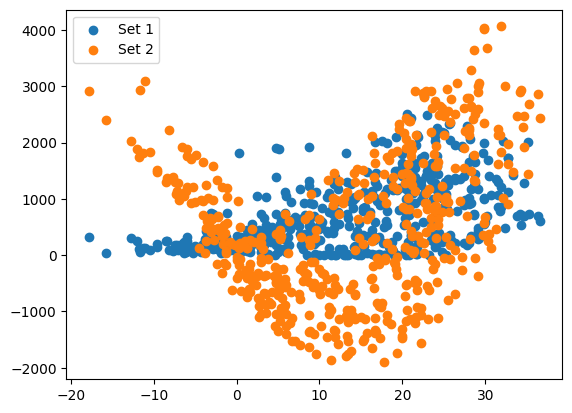

In [218]:
import matplotlib.pyplot as plt

best_ind = tools.selBest(pop, 1)[0]
print(best_ind)
print(toolbox.evaluate(best_ind, myNet))
myNet.setWeightsLinear(best_ind)
print(toolbox.evaluate(best_ind, myNet))

inputs = [[data['Hour'][i],data['Temp'][i], data['Windspeed'][i], data['HireAvailable'][i], data['PublicHoliday'][i], data['Weekend'][i], data['Month'][i]] for i in range(len(data))]
# Assuming you have two sets of data:
x_values1 = data['Temp'].to_list()
y_values1 = data['Count'].to_list()

x_values2 = data['Temp'].to_list()
y_values2 = [myNet.feedForward(i) for i in inputs] 

print(y_values2)
plt.scatter(x_values1, y_values1, label='Set 1')
plt.scatter(x_values2, y_values2, label='Set 2')

# Add a legend to explain which line is which
plt.legend()

# Display the plot
plt.show()

[array([972.80210395]), array([1980.76621326]), array([1276.87855831]), array([1610.38108338]), array([-252.03127018]), array([1453.43426737]), array([89.64397298]), array([359.50189367]), array([491.59136297]), array([2816.12040438]), array([1856.10537974]), array([930.15480679]), array([-689.10444402]), array([755.14965976]), array([-1114.3128699]), array([-263.3660174]), array([-1479.11686728]), array([-971.6950527]), array([-876.10556083]), array([-1440.7552715]), array([266.49683205]), array([1357.7798301]), array([1380.61033351]), array([-1629.39774477]), array([643.9997356]), array([-371.38418998]), array([-328.44786599]), array([-743.38180671]), array([1300.44549666]), array([1586.09223583]), array([-568.49555892]), array([1614.93148347]), array([123.96982336]), array([-1097.24674393]), array([-1434.88681811]), array([215.76354828]), array([-623.81373016]), array([479.97002183]), array([2687.0088031]), array([-620.07225252]), array([1025.4940972]), array([-173.98670274]), array

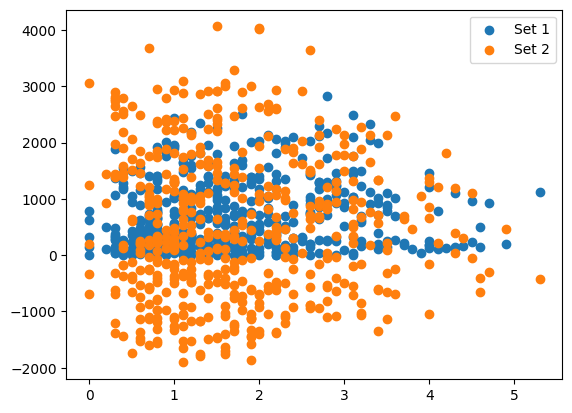

In [219]:
# Assuming you have two sets of data:
x_values1 = data['Windspeed'].to_list()
y_values1 = data['Count'].to_list()

x_values2 = data['Windspeed'].to_list()
y_values2 = [myNet.feedForward(i) for i in inputs] 

print(y_values2)
plt.scatter(x_values1, y_values1, label='Set 1')
plt.scatter(x_values2, y_values2, label='Set 2')

# Add a legend to explain which line is which
plt.legend()

# Display the plot
plt.show()

[array([972.80210395]), array([1980.76621326]), array([1276.87855831]), array([1610.38108338]), array([-252.03127018]), array([1453.43426737]), array([89.64397298]), array([359.50189367]), array([491.59136297]), array([2816.12040438]), array([1856.10537974]), array([930.15480679]), array([-689.10444402]), array([755.14965976]), array([-1114.3128699]), array([-263.3660174]), array([-1479.11686728]), array([-971.6950527]), array([-876.10556083]), array([-1440.7552715]), array([266.49683205]), array([1357.7798301]), array([1380.61033351]), array([-1629.39774477]), array([643.9997356]), array([-371.38418998]), array([-328.44786599]), array([-743.38180671]), array([1300.44549666]), array([1586.09223583]), array([-568.49555892]), array([1614.93148347]), array([123.96982336]), array([-1097.24674393]), array([-1434.88681811]), array([215.76354828]), array([-623.81373016]), array([479.97002183]), array([2687.0088031]), array([-620.07225252]), array([1025.4940972]), array([-173.98670274]), array

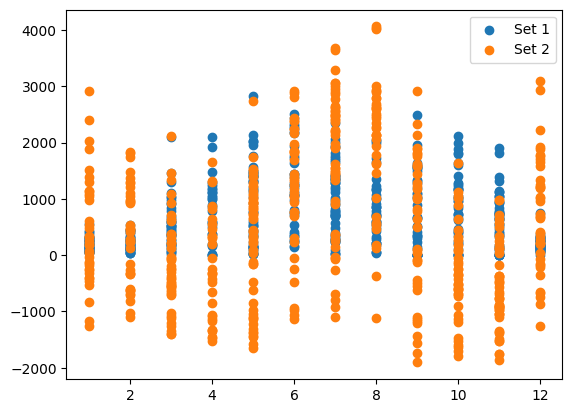

In [220]:
# Assuming you have two sets of data:
x_values1 = data['Month'].to_list()
y_values1 = data['Count'].to_list()

x_values2 = data['Month'].to_list()
y_values2 = [myNet.feedForward(i) for i in inputs] 

print(y_values2)
plt.scatter(x_values1, y_values1, label='Set 1')
plt.scatter(x_values2, y_values2, label='Set 2')

# Add a legend to explain which line is which
plt.legend()

# Display the plot
plt.show()